Approach 2, second try:
- Scientist receives conversation. 
- Goes through the conversational flow.
- Queries the graph.
- Save query in history of queries. 
- Save Query results in history of query results. 
- ToolMessage is not saved in conversation messages.
- Have a variable for the extracted occupations or traits.

In [1]:
# LangChain
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.graphs import Neo4jGraph
from langchain_core.tools import tool
from langchain_groq import ChatGroq

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# LangSmith
from langsmith import traceable

# General Imports
import os
import ast
import prompts 
import operator
from pathlib import Path
from dotenv import load_dotenv
from typing import TypedDict, Annotated # to construct the agent's state
from IPython.display import Image, display

# Connect to graph
dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)
os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
graph = Neo4jGraph()

# Create the tool to be used by the Agent
@tool
def query_graph(query):
  """Query from Neo4j knowledge graph using Cypher."""
  return graph.query(query)

In [2]:
# Create Agent's State
class AgentState(TypedDict):
    conversation: Annotated[list[ AnyMessage ], operator.add]
    good_cypher: Annotated[list[ str ], operator.add]
    bad_cypher: Annotated[list[ str ], operator.add]
    
    queries_to_be_made: list[str]

# Create Agent
class Agent:

    def __init__(self, model, tools, system):
        self.system = system
        self.tools = {t.name: t for t in tools} # Save the tools' names that can be used
        self.model = model.bind_tools(tools) # Provide the name of the tools to the agent

        graph = StateGraph(AgentState) # Initialize a stateful graph
        memory = MemorySaver()

        graph.add_node("personality_scientist", self.call_groq) # LLM node
        graph.add_node("validate_query", self.validate_query) # Checks if query is new
        graph.add_conditional_edges("personality_scientist", self.validate_tool_call, {True: 'validate_query', False: END})
        graph.set_entry_point("personality_scientist")

        # Build graph
        self.graph = graph.compile(checkpointer=memory)
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    ## Get the LLM's response and update the Agent's State by adding the response to the messages
    @traceable
    def call_groq(self, state: AgentState):
        messages = state['conversation']
        
        if self.system: 
            conversation = [SystemMessage(content=self.system)] + messages
        
        ai_response = self.model.invoke(conversation)

        return {'conversation': [ai_response]}
    
    ## Check if the model called for an action by checking the last message in the conversation
    def validate_tool_call(self, state: AgentState):
        ai_message = state['conversation'][-1]
        return len(ai_message.tool_calls) > 0
    
    def validate_query(self, state: AgentState):
        print(f"\n------- in validate query")
        tool_calls = state['conversation'][-1].tool_calls
        new_cypher_queries = []
        existing_cypher_queries = []
        for i in range(len(tool_calls)):
            new_cypher = tool_calls[i]['args']['query']
            if new_cypher in state['good_cypher']:


        return

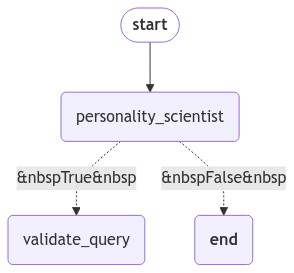

In [3]:
model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")
# model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama3-70b-8192")

agent = Agent(model=model, tools=[query_graph], system=prompts.personality_scientist_prompt.format(schema=graph.structured_schema))

In [7]:
thread = {'configurable': {'thread_id': "1"}}
output = agent.graph.stream({"conversation": [HumanMessage(content="option 1")]}, thread, stream_mode='values')

for message in output:
    message['conversation'][-1].pretty_print()

================================ Human Message =================================

option 1
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_3dam)
 Call ID: call_3dam
  Args:
    query: MATCH (n:Personality_Trait)-[]->(m:Occupation) RETURN m.title

------- in validate query


In [13]:
agent.graph.get_state(thread).values['conversation'][-1].tool_calls[0]['args']['query']

'MATCH (n:Personality_Trait)-[]->(m:Occupation) RETURN m.title'